In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH="/home/ubuntu/dataset-xray"

In [3]:
from pathlib import Path
from covidframe.tools.load import load_database_from_hdf

In [4]:
base_dir = Path(BASE_PATH)
DEFAULT_DATABASE_NAME_TRAIN = "database_balanced_train.h5"
DEFAULT_DATABASE_NAME_TEST = "database_balanced_test.h5"

In [5]:
df_train = load_database_from_hdf(filename= base_dir / DEFAULT_DATABASE_NAME_TRAIN)
df_test = load_database_from_hdf(filename= base_dir / DEFAULT_DATABASE_NAME_TEST)

In [6]:
category_mappings = {
    "normal":0,
    "pneumonia":1,
    "covid-19":2
}

In [7]:
import numpy as np

In [8]:
import tensorflow as tf

In [9]:
import tensorflow.compat.v1 as tf1

In [10]:
model_dir=Path("/home/ubuntu/COVID-Net/models/COVIDNet-CXR4-C")
meta_name="model.meta"
ckpt_name="model-3090"

In [ ]:
#tf1.Session().close()
#doesn't work eager mode
def covidnet_wrapper():
  # Any graph-building code is allowed here.
  tf1.train.import_meta_graph(model_dir / meta_name)

x = import_graph.get_tensor_by_name('input_2:0')
y = import_graph.get_tensor_by_name('softmax/Softmax:0')

# Creates a tf.function with all the imported elements in the function graph.
wrapped_import = tf1.wrap_function(covidnet_wrapper, [])
import_graph = wrapped_import.graph

# Restore the variable values.
tf1.train.Saver(wrapped_import.variables).restore(
    sess=None, save_path= str(model_dir / ckpt_name))

covid_fn = wrapped_import.prune(feeds=x, fetches=y)

In [11]:
X_test = np.stack(df_test["resized"])

In [12]:
df_test["resized_3d"] = df_test["resized"].apply(lambda x: np.tile(x[...,None],3))

In [13]:
from covidframe.tools.image import resize_image

In [14]:
df_test["resized_covidnet"] = df_test["resized_3d"].apply(lambda x: resize_image(x,(480,480)))

In [15]:
X_test_cov = np.stack(df_test["resized_covidnet"])

In [16]:
X_test_cov.shape

(2433, 480, 480, 3)

In [39]:
## For covid net requires medusa backbone image input
df_test["resized_covidnet_medusa"] = df_test["resized"].apply(lambda x: resize_image(x,(256,256)))
df_test["resized_covidnet_medusa"] = df_test["resized_covidnet_medusa"].apply(lambda x: x.astype("float64"))
df_test["resized_covidnet_medusa"] = df_test["resized_covidnet_medusa"].apply(lambda x: x- x.mean())
df_test["resized_covidnet_medusa"] = df_test["resized_covidnet_medusa"].apply(lambda x: x / x.std())
df_test["resized_covidnet_medusa"] = df_test["resized_covidnet_medusa"].apply(lambda x: np.expand_dims(x,-1))

In [40]:
X_test_cov_medusa = np.stack(df_test["resized_covidnet_medusa"])

In [42]:
X_test_cov_medusa[:5].shape

(5, 256, 256, 1)

In [45]:
X_test_cov[:5].shape

(5, 480, 480, 3)

In [17]:
import matplotlib.pyplot as plt

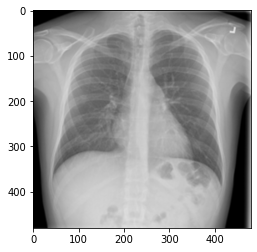

In [18]:
plt.imshow(X_test_cov[0])

In [19]:
X_test_cov[0]/255

array([[[0.0745098 , 0.0745098 , 0.0745098 ],
        [0.05882353, 0.05882353, 0.05882353],
        [0.04313725, 0.04313725, 0.04313725],
        ...,
        [0.78431373, 0.78431373, 0.78431373],
        [0.85098039, 0.85098039, 0.85098039],
        [0.89803922, 0.89803922, 0.89803922]],

       [[0.05882353, 0.05882353, 0.05882353],
        [0.04705882, 0.04705882, 0.04705882],
        [0.02745098, 0.02745098, 0.02745098],
        ...,
        [0.72156863, 0.72156863, 0.72156863],
        [0.80784314, 0.80784314, 0.80784314],
        [0.87058824, 0.87058824, 0.87058824]],

       [[0.03921569, 0.03921569, 0.03921569],
        [0.02745098, 0.02745098, 0.02745098],
        [0.01176471, 0.01176471, 0.01176471],
        ...,
        [0.63137255, 0.63137255, 0.63137255],
        [0.74901961, 0.74901961, 0.74901961],
        [0.83529412, 0.83529412, 0.83529412]],

       ...,

       [[0.01568627, 0.01568627, 0.01568627],
        [0.01568627, 0.01568627, 0.01568627],
        [0.01568627, 0

In [20]:
pred = []
with tf.Graph().as_default() as g:
    meta = tf1.train.import_meta_graph(str(model_dir / meta_name))
    x = g.get_tensor_by_name('input_1:0')
    y = g.get_tensor_by_name('norm_dense_1/Softmax:0')
    with tf1.Session() as sess:
        meta.restore(sess, str(model_dir / ckpt_name))
        for x_element in X_test_cov:
            pred.append(np.array(sess.run(y, feed_dict={x: np.expand_dims(x_element.astype('float32')/255, axis=0)})).argmax(axis=1))

INFO:tensorflow:Restoring parameters from /home/ubuntu/COVID-Net/models/COVIDNet-CXR4-C/model-3090


In [24]:
pred = np.array(pred)
pred

array([[0],
       [1],
       [2],
       ...,
       [2],
       [1],
       [2]])

In [25]:
y_test = df_test["category"].map(category_mappings)

In [26]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, classification_report

In [46]:
matrix = confusion_matrix(y_test, pred.ravel())
matrix = matrix.astype('int')
print(matrix)

[[674  23 114]
 [ 67 598 146]
 [206 269 336]]


In [47]:
import seaborn as sns

[Text(33.0, 0.5, 'True-label'), Text(0.5, 15.0, 'Predicted-label')]

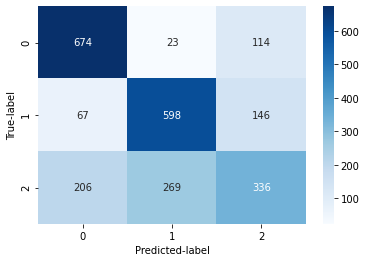

In [48]:
f = sns.heatmap(matrix, annot=True, fmt='d', cmap="Blues")
f.set(xlabel='Predicted-label', ylabel='True-label')

In [34]:
df_test["resized_covidnet"]

0       [[[19, 19, 19], [15, 15, 15], [11, 11, 11], [7...
1       [[[141, 141, 141], [137, 137, 137], [130, 130,...
2       [[[98, 98, 98], [96, 96, 96], [95, 95, 95], [9...
3       [[[15, 15, 15], [14, 14, 14], [14, 14, 14], [1...
4       [[[110, 110, 110], [106, 106, 106], [101, 101,...
                              ...                        
2428    [[[179, 179, 179], [182, 182, 182], [186, 186,...
2429    [[[206, 206, 206], [204, 204, 204], [201, 201,...
2430    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
2431    [[[10, 10, 10], [8, 8, 8], [5, 5, 5], [3, 3, 3...
2432    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
Name: resized_covidnet, Length: 2433, dtype: object

In [35]:
from covidframe.preprocess.equalization import apply_equalization

In [37]:
X_eq_simple = df_test["resized"].apply(lambda x: apply_equalization(x,"simple"))

In [38]:
X_eq_simple = X_eq_simple.apply(lambda x: np.tile(x[...,None],3)).apply(lambda x: resize_image(x,(480,480)))

In [39]:
X_eq_simple.shape

(2433,)

In [40]:
X_eq_simple = np.stack(X_eq_simple)

In [41]:
X_eq_simple.shape

(2433, 480, 480, 3)

In [42]:
pred_2 = []
with tf.Graph().as_default() as g:
    meta = tf1.train.import_meta_graph(str(model_dir / meta_name))
    x = g.get_tensor_by_name('input_1:0')
    y = g.get_tensor_by_name('norm_dense_1/Softmax:0')
    with tf1.Session() as sess:
        meta.restore(sess, str(model_dir / ckpt_name))
        for x_element in X_eq_simple:
            pred_2.append(np.array(sess.run(y, feed_dict={x: np.expand_dims(x_element.astype('float32')/255, axis=0)})).argmax(axis=1))

INFO:tensorflow:Restoring parameters from /home/ubuntu/COVID-Net/models/COVIDNet-CXR4-C/model-3090


In [49]:
matrix2 = confusion_matrix(y_test, np.array(pred_2).ravel())
matrix2 = matrix2.astype('int')
print(matrix)

[[674  23 114]
 [ 67 598 146]
 [206 269 336]]


[Text(33.0, 0.5, 'True-label'), Text(0.5, 15.0, 'Predicted-label')]

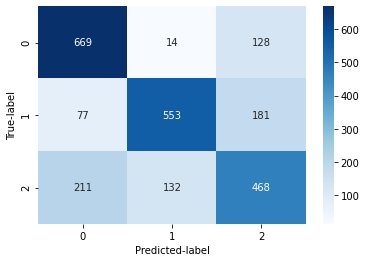

In [50]:
f = sns.heatmap(matrix2, annot=True, fmt='d', cmap="Blues")
f.set(xlabel='Predicted-label', ylabel='True-label')

In [51]:
X_eq_clahe = df_test["resized"].apply(lambda x: apply_equalization(x))

In [52]:
X_eq_clahe = X_eq_clahe.apply(lambda x: np.tile(x[...,None],3)).apply(lambda x: resize_image(x,(480,480)))

In [53]:
X_eq_clahe = np.stack(X_eq_clahe)

In [54]:
pred_3 = []
with tf.Graph().as_default() as g:
    meta = tf1.train.import_meta_graph(str(model_dir / meta_name))
    x = g.get_tensor_by_name('input_1:0')
    y = g.get_tensor_by_name('norm_dense_1/Softmax:0')
    with tf1.Session() as sess:
        meta.restore(sess, str(model_dir / ckpt_name))
        for x_element in X_eq_clahe:
            pred_3.append(np.array(sess.run(y, feed_dict={x: np.expand_dims(x_element.astype('float32')/255, axis=0)})).argmax(axis=1))

INFO:tensorflow:Restoring parameters from /home/ubuntu/COVID-Net/models/COVIDNet-CXR4-C/model-3090


In [55]:
matrix3 = confusion_matrix(y_test, np.array(pred_3).ravel())
matrix3 = matrix3.astype('int')
print(matrix)

[[674  23 114]
 [ 67 598 146]
 [206 269 336]]


[Text(33.0, 0.5, 'True-label'), Text(0.5, 15.0, 'Predicted-label')]

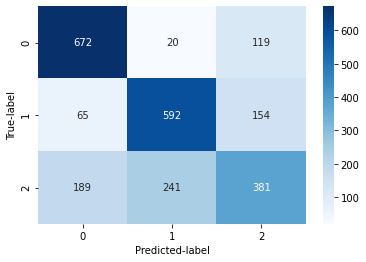

In [56]:
f = sns.heatmap(matrix3, annot=True, fmt='d', cmap="Blues")
f.set(xlabel='Predicted-label', ylabel='True-label')

## Training

In [11]:
image_paths = df_train["image_path"]

In [12]:
image_paths[0]

'/mnt/Archivos/dataset-xray/database_clean/COVID-19_Radiography_Dataset_COVID-2966.png'

In [13]:
ORIGINAL_BASE_PATH="/mnt/Archivos/dataset-xray"

In [14]:
df_train["new_path"] =  df_train["image_path"].apply(lambda x: str(base_dir / Path(x).relative_to(ORIGINAL_BASE_PATH)))

In [15]:
image_paths = df_train["new_path"]

In [16]:
image_paths[0]

'/home/ubuntu/dataset-xray/database_clean/COVID-19_Radiography_Dataset_COVID-2966.png'

In [22]:
from covidframe.tools.image import to_equal_aspect_ratio, resize_image, load_image
import numpy as np

In [23]:
def process_image_file(image_path,size=(480,480)):
    img = load_image(str(image_path))
    img = to_equal_aspect_ratio(img)
    img = resize_image(img, size)
    return np.tile(img[...,None],3)

In [24]:
img = process_image_file(image_paths[0])

In [25]:
img.shape

(480, 480, 3)

In [26]:
y = df_train["category"].map(category_mappings)

In [27]:
y

0       2
1       1
2       1
3       2
4       2
       ..
9727    1
9728    2
9729    2
9730    0
9731    0
Name: category, Length: 9732, dtype: int64

In [29]:
import matplotlib.pyplot as plt

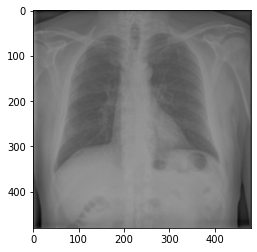

In [30]:
plt.imshow(img)

In [ ]:
#https://cs230.stanford.edu/blog/createtrainmodel/

In [31]:
class CovidDatasetSequence(tf.keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(
            self,
            X_path,
            y,
            is_training=True,
            batch_size=8,
            medusa_input_shape=(256, 256),
            input_shape=(480, 480),
            n_classes=3,
            num_channels=3,
            mapping={
                'negative': 0,
                'positive': 1,
            },
            shuffle=True,
            #augmentation=apply_augmentation,
            covid_percent=0.5,
            class_weights=[1., 1.],
            top_percent=0.08,
            is_severity_model=False,
            is_medusa_backbone=False,
    ):
        'Initialization'
        self.dataset = X_path
        self.y = y
        self.is_training = is_training
        self.batch_size = batch_size
        self.N = len(self.dataset)
        self.medusa_input_shape = medusa_input_shape
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.num_channels = num_channels
        self.mapping = mapping
        self.shuffle = shuffle
        self.covid_percent = covid_percent
        self.class_weights = class_weights
        self.n = 0
        #self.augmentation = augmentation
        self.top_percent = top_percent
        self.is_severity_model = is_severity_model
        self.is_medusa_backbone = is_medusa_backbone

        # If using MEDUSA backbone load images without crop
        if self.is_medusa_backbone:
            self.load_image = partial(process_image_file, top_percent=0, crop=False)
        else:
            self.load_image = process_image_file

        datasets = {}
        self.keys = list(set(self.y))
        for key in self.keys:
            datasets[key] = []
        
        for path, y in zip(self.dataset, self.y):
            datasets[y].append(path)
        
        self.datasets = datasets

        #for l in self.dataset:
        #    datasets[l.split()[2]].append(l)
        
        #if self.is_severity_model:
        #    self.datasets = [
        #        datasets['level2'], datasets['level1']
        #    ]
        #elif self.n_classes == 2:
        #    self.datasets = [
        #        datasets['negative'], datasets['positive']
        #    ]
        #elif self.n_classes == 3:
        #    self.datasets = [
        #        datasets['normal'] + datasets['pneumonia'],
        #        datasets['COVID-19'],
        #    ]
        #else:
        #    raise Exception('Only binary or 3 class classification currently supported.')
        #print(len(self.datasets[0]), len(self.datasets[1]))

        self.on_epoch_end()

    def __next__(self):
        # Get one batch of data
        model_inputs = self.__getitem__(self.n)
        # Batch index
        self.n += 1

        # If we have processed the entire dataset then
        if self.n >= self.__len__():
            self.on_epoch_end()
            self.n = 0

        return model_inputs

    def __len__(self):
        return int(np.ceil(len(self.dataset) / float(self.batch_size)))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            for key in self.datasets:
                np.random.shuffle(self.datasets[key])

    def __getitem__(self, idx):
        batch_x = np.zeros((self.batch_size, *self.input_shape, self.num_channels))
        batch_y = np.zeros(self.batch_size)

        if self.is_medusa_backbone:
            batch_sem_x = np.zeros((self.batch_size, *self.medusa_input_shape, 1))


        acc = 0
        batch_files = []
        y= []
        for i, key in enumerate(self.keys[:-1]):
            n_size = int(self.batch_size/len(self.keys))
            batch_files += self.datasets[key][idx * n_size:(idx + 1) * n_size]
            y += [key]*n_size
            acc += n_size
        
        n_size = self.batch_size -acc
        batch_files += self.datasets[self.keys[-1]][idx * n_size:(idx + 1) * n_size]
        y += [self.keys[-1]]*n_size

        # upsample covid cases
        #covid_size = max(int(len(batch_files) * self.covid_percent), 1)
        #covid_inds = np.random.choice(np.arange(len(batch_files)),
        #                              size=covid_size,
        #                              replace=False)
        #covid_files = np.random.choice(self.datasets[1],
        #                               size=covid_size,
        #                               replace=False)
        #for i in range(covid_size):
        #    batch_files[covid_inds[i]] = covid_files[i]

        for i in range(len(batch_files)):
            #sample = batch_files[i].split()

            #if self.is_training:
            #    folder = 'train'
            #else:
            #    folder = 'test'

            image_file = str(batch_files[i])
            x = self.load_image(
                image_file,
                self.input_shape
            )

            #f self.is_training and hasattr(self, 'augmentation'):
            #   x = self.augmentation(x)

            x = x.astype('float32') / 255.0

            if self.is_medusa_backbone:
                sem_x = process_image_file_medusa(image_file, self.medusa_input_shape[0])
                batch_sem_x[i] = sem_x
            
            #y = self.mapping[sample[2]]

            batch_x[i] = x
            batch_y[i] = y[i]

        class_weights = self.class_weights
        weights = np.take(class_weights, batch_y.astype('int64'))
        batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=self.n_classes)

        if self.is_medusa_backbone:
            return batch_sem_x, batch_x, batch_y, weights, self.is_training
        else:
            return batch_x, batch_y, weights, self.is_training

In [32]:
generator = CovidDatasetSequence(
            image_paths,
            y,
            is_training=True,
            batch_size=18,
            medusa_input_shape=(256, 256),
            input_shape=(480, 480),
            n_classes=3,
            num_channels=3,
            mapping={
                'negative': 0,
                'positive': 1,
            },
            shuffle=True,
            #augmentation=apply_augmentation,
            #covid_percent=0.5,
            class_weights=[1., 1.,1.],
            #top_percent=0.08,
            is_severity_model=False,
            is_medusa_backbone=False)

In [33]:
len(generator)

541

In [34]:
len(image_paths)

9732

In [35]:
batch_x, batch_y, weights, is_training = next(generator)

In [36]:
batch_x.shape

(18, 480, 480, 3)

In [37]:
batch_y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [38]:
learning_rate=0.1

In [46]:
X_test_cov.shape

(2433, 480, 480, 3)

In [47]:
N_EPOCHS=50
DISPLAY_STEP=1

In [49]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, classification_report

In [56]:
with tf.Graph().as_default() as g:
    meta = tf1.train.import_meta_graph(str(model_dir / meta_name))
    x = g.get_tensor_by_name('input_1:0')
    y = g.get_tensor_by_name('norm_dense_1/Softmax:0')
    image_tensor = g.get_tensor_by_name('input_1:0')
    labels_tensor = g.get_tensor_by_name('norm_dense_1_target:0')
    sample_weights = g.get_tensor_by_name('norm_dense_1_sample_weights:0')
    pred_tensor = g.get_tensor_by_name('norm_dense_1/MatMul:0')
    training_tensor = g.get_tensor_by_name('keras_learning_phase:0')
    
    #Optimizer
    loss_op = tf.reduce_mean(tf1.nn.softmax_cross_entropy_with_logits_v2(
                                logits=pred_tensor, labels=labels_tensor)*sample_weights)
    optimizer = tf1.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)
    
    with tf1.Session() as sess:
        #meta.restore(sess, str(model_dir / ckpt_name))
        sess.run(tf1.global_variables_initializer())
        #print(sess.run(y, feed_dict={x: X_test_cov[:5]}))
        # Training cycle
        pred = []
        for x_element in X_test_cov[:100]:
            pred.append(np.array(sess.run(y, feed_dict={x: np.expand_dims(x_element.astype('float32')/255, axis=0)})).argmax(axis=1))
        matrix = confusion_matrix(y_test[:100], pred)
        matrix = matrix.astype('float')
        print(matrix)
        
        print('Training started')
        total_batch = len(generator)
        progbar = tf.keras.utils.Progbar(total_batch)
        for epoch in range(N_EPOCHS):
            for i in range(total_batch):
                # Run optimization
                batch_x, batch_y, weights, is_training = next(generator)
                sess.run(train_op, feed_dict={image_tensor: batch_x,
                                              labels_tensor: batch_y,
                                              sample_weights: weights,
                                              training_tensor: is_training})
                progbar.update(i+1)

            if epoch % DISPLAY_STEP == 0:
                pred = sess.run(pred_tensor, feed_dict={image_tensor:batch_x})
                loss = sess.run(loss_op, feed_dict={pred_tensor: pred,
                                                    labels_tensor: batch_y,
                                                    sample_weights: weights})
                print("Epoch:", '%04d' % (epoch + 1), "Minibatch loss=", "{:.9f}".format(loss))
                
                new_pred = []
                for x_element in X_test_cov[:100]:
                    new_pred.append(np.array(sess.run(y, feed_dict={x: np.expand_dims(x_element.astype('float32')/255, axis=0)})).argmax(axis=1))
                matrix = confusion_matrix(y_test[:100], new_pred)
                matrix = matrix.astype('float')
                print(matrix)
                
                meta.save(sess, str(model_dir / 'my-model'), global_step=epoch+1, write_meta_graph=False)
                print('Saving checkpoint at epoch {}'.format(epoch + 1))

[[ 0. 30.  0.]
 [ 0. 37.  0.]
 [ 0. 33.  0.]]
Training started
541/541 [==============================] - 13772s 25s/step
Epoch: 0001 Minibatch loss= nan
[[30.  0.  0.]
 [37.  0.  0.]
 [33.  0.  0.]]
Saving checkpoint at epoch 1
 11/541 [..............................] - ETA: 189:37:53

KeyboardInterrupt: 